<a href="https://colab.research.google.com/github/FranzaD/ml_hackathon/blob/main/MLHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import sqlite3 #for handling the database file with SQL

from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np

from bs4 import BeautifulSoup
import re

!pip install nltk
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing

!pip install category_encoders
import category_encoders as ce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 3.8 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


NEED TO establish a connection object to interact with a SQLite database

Starts session with: sqlite3.connect(object)
Ends sessions with:  .close(object)

While the connection is open, any interactions with the database require you to make a cursor object with the .cursor() command. The cursor is then ready to perform all kinds of operations with .execute().
________________________________
[QUERIES:](https://datacarpentry.org/python-ecology-lesson/09-working-with-sql/index.html)

One of the most common ways to interact with a database is by querying: retrieving data based on some search parameters. Use a SELECT statement string. The query is returned as a single tuple or a tuple of tuples. Add a WHERE statement to filter your results based on some parameter.

PANDAS:
Using pandas, we can import results of a SQLite query into a dataframe. Note that you can use the same SQL commands / syntax that we used in the SQLite lesson.

# Recommendation System in PapersWithCode

In [ ]:
path = "/content/drive/Shareddrives/ML Hackathon/paperswithcode.db"

conn = sqlite3.connect(path) #connection object opened

query='''
	SELECT name
	FROM sqlite_master
	WHERE type= "table"
	'''
result=pd.read_sql(query, conn)

Relevant Pandas Function: Head()

head(n) is used to return the first n rows of a dataset. By default, df.head() will return the first 5 rows of the DataFrame. If you want more/less number of rows, you can specify n as an integer.

In [ ]:
#Select all dataset metadata
query="SELECT * FROM datasets"
result=pd.read_sql(query, conn)
print(result.head())

                                           url      name  \
0     https://paperswithcode.com/dataset/mnist     MNIST   
1    https://paperswithcode.com/dataset/celeba    CelebA   
2  https://paperswithcode.com/dataset/jft-300m  JFT-300M   
3      https://paperswithcode.com/dataset/glue      GLUE   
4  https://paperswithcode.com/dataset/multinli  MultiNLI   

                                           full_name  \
0                                                      
1                      CelebFaces Attributes Dataset   
2                                           JFT-300M   
3  General Language Understanding Evaluation benc...   
4             Multi-Genre Natural Language Inference   

                                           homepage  \
0                 http://yann.lecun.com/exdb/mnist/   
1  http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html   
2                                                     
3                        https://gluebenchmark.com/   
4           https://cims.ny

In [ ]:
#Select target values (similar_datasets) for each dataset
query="SELECT name, similar_datasets FROM datasets"
result=pd.read_sql(query, conn)
print(result)

          name                                   similar_datasets
0        MNIST      ['USPS', 'SVHN', 'Fashion-MNIST', 'CIFAR-10']
1       CelebA                      ['FFHQ', 'LSUN', 'CelebA-HQ']
2     JFT-300M  ['JFT-3B', 'IG-3.5B-17k', 'ObjectNet', 'Tencen...
3         GLUE               ['SST', 'SuperGLUE', 'CoLA', 'MRPC']
4     MultiNLI  ['RTE', 'Quora Question Pairs', 'STS Benchmark...
...        ...                                                ...
5801   L3DAS22                                        ['L3DAS21']
5802   MS-FIMU                                 ['Adult Data Set']
5803   RoomEnv                                               ['']
5804    VFITex                                        ['BVI-DVC']
5805    HONEST    ['CrowS-Pairs', 'ETHICS', 'Blended Skill Talk']

[5806 rows x 2 columns]


# **Here I'm trying to get a better idea of the dataset & testing different Pandas functions:**

In [ ]:
#Select target values (similar_datasets) for each dataset
query="SELECT * FROM datasets"
data=pd.read_sql(query, conn)
#shows all columns of dataset
data.columns



Index(['url', 'name', 'full_name', 'homepage', 'description',
       'introduced_date', 'warning', 'modalities', 'tasks', 'languages',
       'variants', 'num_papers', 'data_loaders', 'paper_title', 'paper_url',
       'paper', 'similar_datasets'],
      dtype='object')

In [ ]:
#shows the data type of each column
data.dtypes #so they're all objects..interesting

url                 object
name                object
full_name           object
homepage            object
description         object
introduced_date     object
warning             object
modalities          object
tasks               object
languages           object
variants            object
num_papers           int64
data_loaders        object
paper_title         object
paper_url           object
paper               object
similar_datasets    object
dtype: object

In [ ]:
#to check how many unique valuess their are in the modalities column
data.modalities.nunique()

#how many unique values are there for each column
data.nunique()

url                 5806
name                5806
full_name           2313
homepage            5372
description         5711
introduced_date     1310
warning                0
modalities           260
tasks               2772
languages            217
variants            5786
num_papers           286
data_loaders        2060
paper_title         4617
paper_url           4619
paper                  0
similar_datasets    3751
dtype: int64

In [ ]:
#just another way of summarizing the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   url               5806 non-null   object
 1   name              5806 non-null   object
 2   full_name         5523 non-null   object
 3   homepage          5786 non-null   object
 4   description       5806 non-null   object
 5   introduced_date   3676 non-null   object
 6   warning           0 non-null      object
 7   modalities        5806 non-null   object
 8   tasks             5806 non-null   object
 9   languages         5806 non-null   object
 10  variants          5806 non-null   object
 11  num_papers        5806 non-null   int64 
 12  data_loaders      5806 non-null   object
 13  paper_title       4859 non-null   object
 14  paper_url         4859 non-null   object
 15  paper             0 non-null      object
 16  similar_datasets  5806 non-null   object
dtypes: int64(1), o

In [ ]:
df = data
df


,url,name,full_name,homepage,description,introduced_date,warning,modalities,tasks,languages,variants,num_papers,data_loaders,paper_title,paper_url,paper,similar_datasets
0,https://paperswithcode.com/dataset/mnist,MNIST,,http://yann.lecun.com/exdb/mnist/,The **MNIST** database (**Modified National In...,None,None,['Images'],"[{'task': 'Image Classification', 'url': 'http...",[],"['USPS-to-MNIST', 'MNIST-to-USPS', 'Rotating M...",5123,[{'url': 'https://huggingface.co/datasets/mnis...,Gradient-based learning applied to document re...,http://arxiv.org/pdf/1102.0183.pdf,None,"['USPS', 'SVHN', 'Fashion-MNIST', 'CIFAR-10']"
1,https://paperswithcode.com/dataset/celeba,CelebA,CelebFaces Attributes Dataset,http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html,"CelebFaces Attributes dataset contains 202,599...",2015-01-01,None,['Images'],"[{'task': 'Image Classification', 'url': 'http...",[],"['CelebA Aligned', 'CelebA 64x64', 'CelebA 256...",1968,[{'url': 'https://pytorch.org/vision/stable/da...,Deep Learning Face Attributes in the Wild,https://paperswithcode.com/paper/deep-learning...,None,"['FFHQ', 'LSUN', 'CelebA-HQ']"
2,https://paperswithcode.com/dataset/jft-300m,JFT-300M,JFT-300M,,**JFT-300M** is an internal Google dataset use...,2017-07-10,None,['Images'],"[{'task': 'Image Classification', 'url': 'http...",[],['JFT-300M'],65,[],Revisiting Unreasonable Effectiveness of Data ...,https://paperswithcode.com/paper/revisiting-un...,None,"['JFT-3B', 'IG-3.5B-17k', 'ObjectNet', 'Tencen..."
3,https://paperswithcode.com/dataset/glue,GLUE,General Language Understanding Evaluation benc...,https://gluebenchmark.com/,General Language Understanding Evaluation (**G...,2019-01-01,None,['Texts'],"[{'task': 'Text Classification', 'url': 'https...",['English'],"['CHANGE-IT', 'GLUE STSB', 'GLUE SST2', 'GLUE ...",1290,[{'url': 'https://huggingface.co/datasets/glue...,GLUE: A Multi-Task Benchmark and Analysis Plat...,https://paperswithcode.com/paper/glue-a-multi-...,None,"['SST', 'SuperGLUE', 'CoLA', 'MRPC']"
4,https://paperswithcode.com/dataset/multinli,MultiNLI,Multi-Genre Natural Language Inference,https://cims.nyu.edu/~sbowman/multinli/,The **Multi-Genre Natural Language Inference**...,2018-01-01,None,['Texts'],"[{'task': 'Natural Language Inference', 'url':...",['English'],"['MultiNLI', 'MultiNLI Dev']",315,[{'url': 'https://huggingface.co/datasets/mult...,A Broad-Coverage Challenge Corpus for Sentence...,https://paperswithcode.com/paper/a-broad-cover...,None,"['RTE', 'Quora Question Pairs', 'STS Benchmark..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5801,https://paperswithcode.com/dataset/l3das22,L3DAS22,,https://www.kaggle.com/datasets/l3dasteam/l3das22,# L3DAS22: MACHINE LEARNING FOR 3D AUDIO SIGNA...,2021-11-19,None,['Audio'],"[{'task': 'Speech Enhancement', 'url': 'https:...",['English'],['L3DAS22'],4,[],L3DAS22 Challenge: Learning 3D Audio Sources i...,https://paperswithcode.com/paper/l3das22-chall...,None,['L3DAS21']
5802,https://paperswithcode.com/dataset/ms-fimu,MS-FIMU,Mobility Scenario FIMU,https://github.com/hharcolezi/OpenMSFIMU,Open Dataset: Mobility Scenario FIMU\r\n\r\n* ...,2020-06-15,None,['Tabular'],"[{'task': 'Classification', 'url': 'https://pa...",['English'],['MS-FIMU'],0,[],Production of Categorical Data Verifying Diffe...,https://paperswithcode.com/paper/production-of...,None,['Adult Data Set']
5803,https://paperswithcode.com/dataset/roomenv,RoomEnv,The Room Environment,https://github.com/tae898/room-env,# The Room environment\r\n\r\nWe have released...,2022-04-04,None,"['Texts', 'Graphs']",[{'task': 'Multi-agent Reinforcement Learning'...,['English'],['RoomEnv'],0,[],A Machine With Human-Like Memory Systems,https://paperswithcode.com/paper/a-machine-wit...,None,['']
5804,https://paperswithcode.com/dataset/vfitex,VFITex,,https://danielism97.github.io/ST-MFNet/,To test interpolation performance on various t...,2021-11-30,None,[],"[{'task': 'Video Frame Interpolation', 'url': ...",[],['VFITex'],1,[],

# In order to identify Keywords we have to **PREPROCESS the data** using pandas and numpy, this includes:


1.   removing links
2.   removing punctuations
3.   removing numbers
4.   Remove emojis
5.   Remove stop words (what, why, how, etc)
6.   TOKENIZATION: *using NLTK*
       
        this splits the text into tokens, a string is converted to a list,
        eache element is a word
7. Normalize words: *using NLTK with the WordNetLemmatize fxn*

EX: playing -> play, get root word

## 1. Clean text data


In [ ]:
'''
Source:
https://www.analyticsvidhya.com/blog/2021/08/a-friendly-guide-to-nlp-text-pre-processing-with-python-example/
https://www.analyticsvidhya.com/blog/2021/05/how-to-build-word-cloud-in-python/
'''

data["paper_title"].fillna("", inplace = True)
data["full_name"].fillna("", inplace = True)

#remove links
#data["clean_description"] = data["description"].apply(lambda s: ' '.join(re.sub("(w+://S+)", " ", s).split()))
data["clean_description"] = data["description"].apply(lambda s: ' '.join(re.sub(r'http\S+', " ", s).split()))
data[['description','clean_description']].iloc[:] #displays/deletes links for all rows


#display(data)
#print(data['description'][0])
#print(data['clean_description'][0])


#AFTER CLEAN UP:
#then create a new column with the number of keywords
#then try to see if given a specific datset then model recommends datasets with similar key words

#given a dataset, can we identify other datasets with the most similar keywords?

#remove punctuation: seems like * has stayed, have to try to figure out how to potentially remove later
data["clean_description"] = data["clean_description"].apply(lambda s: ' '.join(re.sub(r'[^\w\s]', " ", s).split()))
data["clean_full_name"] = data["full_name"].apply(lambda s: ' '.join(re.sub(r'[^\w\s]', " ", s).split()))
data["clean_paper_title"] = data["paper_title"].apply(lambda s: ' '.join(re.sub(r'[^\w\s]', " ", s).split()))


#remove numbers
data["clean_description"].replace('[0-9\n]', '', regex=True, inplace=True)
data["clean_full_name"].replace('[0-9\n]', '', regex=True, inplace=True)
data["clean_paper_title"].replace('[0-9\n]', '', regex=True, inplace=True)
#data["clean_description"] = re.sub(r'[0-9]', '', )

#remove stop words

#shows list of stop words in the nltk library
stop = nltk.corpus.stopwords.words('english')

text = ""

#remove stop words
def rem_en(input_txt):
    global text
    words = input_txt.lower().split()
    noise_free_words = [word for word in words if word not in stop]
    noise_free_text = " ".join(noise_free_words)
    noise_free_text = noise_free_text.split(" ")
    lemmatizer = WordNetLemmatizer()
    noise_free_text = [lemmatizer.lemmatize(token, pos='v') for token in noise_free_text]
    noise_free_text = " ".join(noise_free_text)
    text += noise_free_text
    return noise_free_text

data["clean_description"] = data["clean_description"].apply(lambda s: rem_en(s))
# data[["description","clean_description"]]
data["clean_full_name"] = data["clean_full_name"].apply(lambda s: rem_en(s))
data["clean_paper_title"] = data["clean_paper_title"].apply(lambda s: rem_en(s))

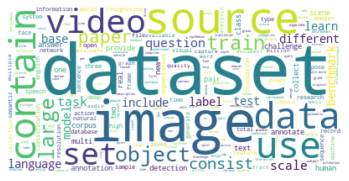

In [ ]:
wordCloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
## preprocess dataset
newData = data.copy()
# delete unused columns/features
newData = newData.drop(columns = ["homepage", "warning", "tasks", "variants", "data_loaders", "paper", "paper_url", "num_papers", "description", "paper_title", "full_name"])
# set null value to empty string (full name, paper title)

# similar_dataset index
nameIndex = {}
for i, j in enumerate(newData["name"]):
  nameIndex[j] = i

# newData
# print(newData.info())

## 2. Preprocess text description (clustering)

### Method1: normal *clustering*

In [ ]:
'''cluster into groups by text using KMeans'''
def Kmeans_train(newData):
  vectorizer = TfidfVectorizer(stop_words='english')
  X = vectorizer.fit_transform(newData["clean_description"])
  # pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names()).head()
  true_k = 100
  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
  model.fit(X)
  # order_centroids = model.cluster_centers_.argsort()[:, ::-1]
  # terms = vectorizer.get_feature_names()

  print("Prediction")
  # lst: list of predicted group by index(row)
  lst = []
  for i in newData["clean_description"]:
    X = vectorizer.transform([i])
    predicted = model.predict(X)
    # print(i, predicted)
    lst.append(predicted)

  return lst



lst = Kmeans_train(newData)
cluster = {} # cluster {group:num of rows in that group}
for i in lst:
  cluster[i[0]] = cluster.get(i[0], 0) + 1
print(cluster.values())

newData["group"] = [i[0] for i in lst]


Prediction
dict_values([5024, 42, 111, 29, 278, 5, 58, 24, 8, 3, 3, 3, 10, 3, 1, 10, 4, 1, 3, 2, 19, 38, 2, 1, 1, 1, 8, 3, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 2, 3, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 3, 3, 1, 3, 2, 1, 1, 2, 1, 1, 2, 2, 4, 2, 1, 1, 1, 1, 2, 1, 1, 1, 3, 2, 4, 3, 1])


(array([2929.,  269.,  460.,  133.,  184.,  468.,  134., 1014.,  121.,
          94.]),
 array([  0. ,  49.9,  99.8, 149.7, 199.6, 249.5, 299.4, 349.3, 399.2,
        449.1, 499. ]),
 <a list of 10 Patch objects>)

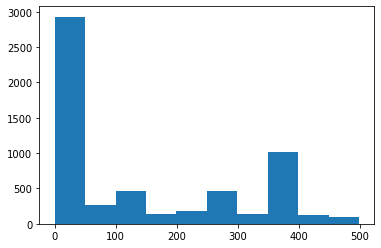

In [ ]:
plt.hist(newData["group"])

### Method2: BERT clustering + KMeans

In [ ]:
'''
Sources:
    https://gist.github.com/yuchenlin/9fceb3533b1a0a4bcc4bf87ab2aa2d21
'''

'\nSources: \n    https://gist.github.com/yuchenlin/9fceb3533b1a0a4bcc4bf87ab2aa2d21\n'

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
newData["text"] = ((newData["clean_description"] + " ") + (newData["clean_full_name"] + " ") * 3 + (newData["clean_paper_title"] + " ") * 7)
# newData["text"] = df[["clean_description", "Duration"]].apply("-".join, axis=1)

In [ ]:
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
corpus = newData["text"]
corpus_embeddings = embedder.encode(corpus, show_progress_bar=True, batch_size=8)


Batches:   0%|          | 0/726 [00:00<?, ?it/s]

In [ ]:
num_clusters = 500
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_
newData["group"] = cluster_assignment

(array([ 9., 15., 28., 12., 17., 16.,  6.,  6., 25., 17., 26.,  4., 10.,
        31.,  4., 21., 14., 23., 26., 12.,  3.,  3., 16., 12., 11.,  9.,
        11., 17.,  8., 23., 15.,  8., 25., 24., 12.,  5., 33.,  1., 12.,
        13.,  8., 22., 11., 20., 17.,  9., 11., 38., 14.,  7.,  5., 36.,
         7., 14., 21.,  9., 13.,  6., 11., 24.,  8., 10.,  8., 11., 15.,
        21., 14., 12., 20., 14., 34.,  8.,  9., 36.,  7., 22., 13., 15.,
        16.,  3.,  4., 34., 13.,  7.,  5., 15., 27.,  9.,  5., 12., 30.,
        27., 13., 10., 14., 10., 20., 14., 14.,  7., 24.,  8.,  5., 27.,
         2., 10., 31., 19., 25., 25., 18.,  4., 12., 16.,  4., 12.,  4.,
        14., 14., 22., 16., 11.,  9.,  4., 11., 18., 15.,  5.,  4., 21.,
         6., 16.,  2.,  7., 16.,  3., 15., 16.,  2., 13.,  3., 13., 27.,
         3., 39.,  5.,  4.,  5., 11., 17.,  7., 11.,  4., 40., 10.,  5.,
        12., 18., 14., 10., 15., 22., 19.,  9., 28.,  3., 20., 17.,  5.,
        11.,  1., 27., 11.,  8., 13.,  3., 26.,  5.

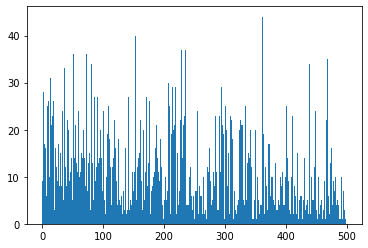

In [ ]:
plt.hist(cluster_assignment, bins=500)

## Preprocess non-text fields

In [ ]:
'''plot the frequency of introduced year -> return year frequency dic'''
def display_date(newData):
  date = {}
  for i in newData["introduced_date"]:
    if i != None:
      year = int(i.strip("'").split("-")[0])
      date[year] = date.get(year, 0) + 1
  # dateList = np.array(list(date.items()))
  # plt.plot(dateList[:, 0], dateList[:, 1], "o")
  return date
# display_date(newData)

'''categorized date into {0: <2000 | None val, 1: 2000~2009, 2: 2010~2019,
3: >2020}'''
def cat_date(newData):
  for i, row in newData.iterrows():
    date = newData.iloc[i]["introduced_date"]
    # print(date)
    if date == None or date.startswith("1"):
      newData.at[i, "introduced_date"] = 0
      # print("hello", newData.iloc[i]["introduced_date"])
    elif date.startswith("200"):
      newData.at[i, "introduced_date"] = 1
    elif date.startswith("201"):
      newData.at[i, "introduced_date"] = 2
    elif date.startswith("202"):
      newData.at[i, "introduced_date"] = 3
  # print(newData["introduced_date"])


'''categorized language into {1: English, 0: Non-English}'''
def cat_language(newData):
  for i, row in newData.iterrows():
    language = newData.iloc[i]["languages"]
    if language == "['English']":
      newData.at[i, "languages"] = 1
    else:
      newData.at[i, "languages"] = 0

'''transfer data from string to list on a column'''
def data_to_list(newData, colname):
  for i, row in newData.iterrows():
    col = newData.iloc[i][colname]
    newData.at[i, colname] = col[2:-2].split("', '")


'''preprocessing data'''
def preprocess_data(newData):
  cat_date(newData)
  cat_language(newData)
  data_to_list(newData, "modalities")
  data_to_list(newData, "similar_datasets")

  newData = newData.explode("modalities")
  newData = newData.explode("similar_datasets")
  # convert similar dataset into indices(row of the dataname in orginal dataset)
  newData["similar_datasets"] = newData["similar_datasets"].apply(lambda x: nameIndex.get(x, 0))
  return newData
newData = preprocess_data(newData)
newData

,url,name,introduced_date,modalities,languages,similar_datasets,clean_description,clean_full_name,clean_paper_title,group
0,https://paperswithcode.com/dataset/mnist,MNIST,0,Images,0,303,mnist database modify national institute stand...,,gradient base learn apply document recognition,29
0,https://paperswithcode.com/dataset/mnist,MNIST,0,Images,0,150,mnist database modify national institute stand...,,gradient base learn apply document recognition,29
0,https://paperswithcode.com/dataset/mnist,MNIST,0,Images,0,14,mnist database modify national institute stand...,,gradient base learn apply document recognition,29
0,https://paperswithcode.com/dataset/mnist,MNIST,0,Images,0,152,mnist database modify national institute stand...,,gradient base learn apply document recognition,29
1,https://paperswithcode.com/dataset/celeba,CelebA,2,Images,0,189,celebfaces attribute dataset contain face imag...,celebfaces attribute dataset,deep learn face attribute wild,29
...,...,...,...,...,...,...,...,...,...,...
5803,https://paperswithcode.com/dataset/roomenv,RoomEnv,3,Graphs,1,0,room environment release challenge openai gym ...,room environment,machine human like memory systems,29
5804,https://paperswithcode.com/dataset/vfitex,VFITex,3,,0,1558,test interpolation performance various texture...,,st mfnet spatio temporal multi flow network fr...,89
5805,https://paperswithcode.com/dataset/honest-en,HONEST,3,Texts,1,1690,honest dataset template base corpus test hurtf...,hurtful sentence completion english language m...,honest measure hurtful sentence completion lan...,29
5805,https://paperswithcode.com/dataset/honest-en,HONEST,3,Texts,1,1818,honest dataset template base corpus test hurtf...,hurtful sentence completion english language m...,honest measure hurtful sentence completion lan...,29


In [ ]:
# Apply Target Encoding on modalities
tenc =ce.TargetEncoder()
modalities = tenc.fit_transform(newData['modalities'],newData['similar_datasets'])
newData['modalities'] = modalities
# normalize modalities
newData['modalities'] = (newData['modalities'] - min(newData['modalities'])) / (max(newData['modalities'])- min(newData['modalities']))


# Trainig Dataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
'''This function calculate the probability where actual and
predict similar_dataset has at least one common feature'''
def calc_probability(Yte, y_pred):
  similar_count = 0
  for i in range(len(y_pred)):
    indexYte = Yte.index[i]
    actual_target = Yte.loc[indexYte]
    pred_target = y_pred[i]
    actual_data = newData.loc[newData['index'] == actual_target]
    predict_data = newData.loc[newData['index'] == pred_target]
    # print(actual_target, pred_target)
    # print(actual_data)
    # print(predict_data)
    b = 0
    if pred_target == actual_target:
        similar_count += 1
    else:
      for k, rowk in actual_data.iterrows():
        for j, rowj in predict_data.iterrows():
          if rowk["introduced_date"] == rowj["introduced_date"] or rowk["modalities"] == rowj["modalities"] or rowk["languages"] == rowj["languages"] or rowk["group"] == rowj["group"]:
            similar_count += 1
            b = 1
            break
        if b == 1:
          break
  return similar_count/len(y_pred)

In [ ]:
# splitting data to Xtr(features for training), Ytr(target for training), Xte(features for testing), Yte(target for testing)
# mldata = newData.copy()
newData = newData.reset_index()
# print(mldata)
newData = newData.sample(frac=1)
# X = mldata.drop(columns=["url", "name", "clean_description", "clean_full_name", "clean_paper_title", "similar_datasets", "index", "text"])
# Y = mldata["similar_datasets"]
# Xtr, Xte, Ytr, Yte = train_test_split(newData.drop(columns=["url", "name", "clean_description", "clean_full_name", "clean_paper_title", "similar_datasets", "index", "text"]), newData["similar_datasets"], test_size=0.3)
Xtr, Xte, Ytr, Yte = train_test_split(newData.drop(columns=["url", "name", "clean_description", "clean_full_name", "clean_paper_title", "similar_datasets", "index"]), newData["similar_datasets"], test_size=0.3)

## Model1: Random Forest

In [ ]:
# Random Forest
rfc=RandomForestClassifier(n_estimators=50)
#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(Xtr,Ytr)

RandomForestClassifier(n_estimators=50)

In [ ]:
# rf_pred_Xtr=rfc.predict(Xtr)
rf_pred_Xte=rfc.predict(Xte)

In [ ]:
# print("Training accuracy (Probability of at least one feature related between prediction and actual similar dataset):", calc_probability(Ytr, rf_pred_Xtr))
print("Testing accuracy (Probability of at least one feature related between prediction and actual similar dataset):", calc_probability(Yte, rf_pred_Xte))

Testing accuracy (Probability of at least one feature related between prediction and actual similar dataset): 0.9790564373897708


## Model 2: Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# training a Naive Bayes classifier
gnb = GaussianNB().fit(Xtr, Ytr)
gnb_pred = gnb.predict(Xte)

In [ ]:
calc_probability(Yte, gnb_pred)

0.9821428571428571

## Model 3: KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_trainprob = []
knn_testprob = []
neighbor_range = [1, 2, 3, 4, 5, 6, 7,8, 9, 10]
# print(neighbor_range)
for i in neighbor_range:
  knn = KNeighborsClassifier(n_neighbors = i).fit(Xtr, Ytr)
  Xtr_pred = knn.predict(Xtr)
  knn_trainprob.append(calc_probability(Ytr, Xtr_pred))
  Xte_pred = knn.predict(Xte)
  knn_testprob.append(calc_probability(Yte, Xte_pred))

Training Probability: [0.9819538926681783, 0.9778911564625851, 0.9807256235827665, 0.9804421768707483, 0.9807256235827665, 0.9808201058201058, 0.9793083900226758, 0.9789304610733183, 0.9764739229024944, 0.9768518518518519]
Testing Probability: [0.9799382716049383, 0.9779541446208113, 0.9797178130511464, 0.9797178130511464, 0.9801587301587301, 0.9783950617283951, 0.9772927689594356, 0.9772927689594356, 0.9757495590828924, 0.9755291005291006]


Text(0.5, 1.0, 'KNN Accuracy')

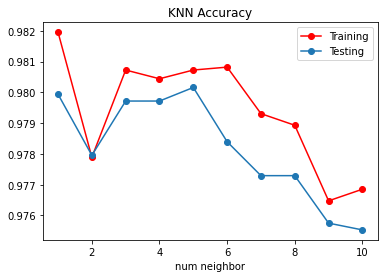

In [ ]:
print("Training Probability:", knn_trainprob)
print("Testing Probability:", knn_testprob)
plt.plot(neighbor_range, knn_trainprob, "or-", label = "Training")
plt.plot(neighbor_range, knn_testprob, "o-", label = "Testing")
plt.legend()
plt.xlabel("num neighbor")
plt.title("KNN Accuracy")

# Recommendation System on ML Repository

In [ ]:
conn = sqlite3.connect('/content/drive/Shareddrives/ML Hackathon/ucimlrepo.db')
#cursor = conn.cursor()


In [ ]:
#%%
#Select all columns and instances from a table
query="SELECT * FROM donated_datasets"
result=pd.read_sql(query, conn)
print(result['isTabular'])

result = result.drop(columns=['introPaperID', 'userID', 'DOI', 'URLFolder', 'URLReadme', 'URLLink', 'Graphics',
       'Status', 'slug'])

result["Area"].fillna("", inplace = True)
result["Task"].fillna("", inplace = True)
result["Types"].fillna("", inplace = True)
result["DateDonated"].fillna(-1, inplace = True)
result["AttributeTypes"].fillna("", inplace = True)
result.info()

0      1
1      1
2      1
3      1
4      1
      ..
597    0
598    1
599    1
600    1
601    1
Name: isTabular, Length: 602, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              602 non-null    int64 
 1   Name            602 non-null    object
 2   Abstract        602 non-null    object
 3   Area            602 non-null    object
 4   Task            602 non-null    object
 5   Types           602 non-null    object
 6   DateDonated     602 non-null    object
 7   isTabular       602 non-null    int64 
 8   NumHits         602 non-null    int64 
 9   NumInstances    602 non-null    int64 
 10  NumAttributes   602 non-null    int64 
 11  AttributeTypes  602 non-null    object
dtypes: int64(5), object(7)
memory usage: 56.6+ KB


In [ ]:
data = result.copy()

def parseListToDict(lst):
  dic = {}
  for l in lst:
    # print(l)
    l = l.split(", ")
    if l != ['']:
      for j in l:
        j = j.lower()
        dic[j] = dic.get(j, 0) + 1
  return dic

def drop_outlier(col, lst):
  # for i in range(len(col)):
  #   if col.iloc[i] in lst:
  pass

task_info = parseListToDict(data["Task"])
types_info = parseListToDict(data["Types"])
AttributeTypes_info = parseListToDict(data["AttributeTypes"])

dropped = [i for i, j in task_info.items() if j < 5]
# drop_outlier(data["Task"], dropped)
data["Task"] = data["Task"].apply(lambda s: s.split(", "))
data["Types"] = data["Types"].apply(lambda s: s.split(", "))
data["AttributeTypes"] = data["AttributeTypes"].apply(lambda s: s.split(", "))
# data["Task"] = data["Task"].apply(lambda s: s.split())

print(data)

      ID                                            Name  \
0      1                                         Abalone   
1      2                                           Adult   
2      3                                       Annealing   
3      4                    Anonymous Microsoft Web Data   
4      5                                      Arrhythmia   
..   ...                                             ...   
597  696                            Open Web Text Corpus   
598  697  Predict students' dropout and academic success   
599  713                            Auction Verification   
600  715           LT-FS-ID: Intrusion detection in WSNs   
601  722      NATICUSdroid (Android Permissions) Dataset   

                                              Abstract              Area  \
0    Predict the age of abalone from physical measu...              Life   
1    Predict whether income exceeds $50K/yr based o...            Social   
2                                 Steel annealing d

In [ ]:
def cat_date(newData):
  for i, row in newData.iterrows():
    date = newData.iloc[i]["DateDonated"]
    if date != -1:
      year = int(date.strip("").split("-")[0])
      # print(year)
      # print(date)
      if year < 1990:
        newData.at[i, "DateDonated"] = 0
        # print("hello", newData.iloc[i]["introduced_date"])
      elif year >= 1990 and year < 2000:
        newData.at[i, "DateDonated"] = 1
      elif year >= 2000 and year < 2010:
        newData.at[i, "DateDonated"] = 2
      elif year >= 2010:
        newData.at[i, "DateDonated"] = 3

def display_date(newData):
  date = {}
  for i in newData["DateDonated"]:
    if i != -1:
      # print(i)
      year = int(i.strip("").split("-")[0])
      date[year] = date.get(year, 0) + 1
  # dateList = np.array(list(date.items()))
  # plt.plot(dateList[:, 0], dateList[:, 1], "o")
  return date
# display_date(data)
cat_date(data)
data

,ID,Name,Abstract,Area,Task,Types,DateDonated,isTabular,NumHits,NumInstances,NumAttributes,AttributeTypes
0,1,Abalone,Predict the age of abalone from physical measu...,Life,[Classification],[Multivariate],1,1,46870,4177,9,"[Categorical, Integer, Real]"
1,2,Adult,Predict whether income exceeds $50K/yr based o...,Social,[Classification],[Multivariate],1,1,85922,48842,15,"[Categorical, Integer]"
2,3,Annealing,Steel annealing data,Physical,[Classification],[Multivariate],-1,1,11850,798,38,"[Categorical, Integer, Real]"
3,4,Anonymous Microsoft Web Data,Log of anonymous users of www.microsoft.com; p...,Computer,[Recommender-Systems],[],1,1,16320,37711,0,[Categorical]
4,5,Arrhythmia,Distinguish between the presence and absence o...,Life,[Classification],[Multivariate],1,1,15391,452,279,"[Categorical, Integer, Real]"
...,...,...,...,...,...,...,...,...,...,...,...,...
597,696,Open Web Text Corpus,We started by extracting all Reddit post urls ...,Other,"[Classification, Regression, Clustering]",[Text],3,0,1250,8013769,0,[]
598,697,Predict students' dropout and academic success,A dataset created from a higher education inst...,Other,[Classification],[Tabular],3,1,2827,4424,0,[]
599,713,Auction Verification,We modeled a simultaneous multi-round auction ...,Computer Science,"[Classification, Regression]",[Tabular],3,1,703,2043,0,[]
600,715,LT-FS-ID: Intrusion detection in WSNs,There exist five columns in this dataset. The ...,Computer Science,[Regression],[Tabular],3,1,273,182,0,[]


In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [ ]:
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
corpus = data["Abstract"]
corpus_embeddings = embedder.encode(corpus, show_progress_bar=True, batch_size=8)

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/555 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/76 [00:00<?, ?it/s]

In [ ]:
num_clusters = 50
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_
data["abstract_group"] = cluster_assignment

In [ ]:
data = data.explode("Task")
data = data.explode("Types")
data = data.explode("AttributeTypes")

In [ ]:
  # label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
data['Area']= label_encoder.fit_transform(data['Area'])
data['Task']= label_encoder.fit_transform(data['Task'])
data['Types']= label_encoder.fit_transform(data['Types'])
data['AttributeTypes']= label_encoder.fit_transform(data['AttributeTypes'])

In [ ]:
import seaborn as sns
import numpy as np

def getUpperLimit(col):
  Q1 = col.quantile(0.25)
  Q3 = col.quantile(0.75)
  # lower_lim = Q1 - 1.5 * (Q3-Q1)
  upper_lim = Q3 + 1.5 * (Q3-Q1)
  return upper_lim
upper_lim = getUpperLimit(data['NumAttributes'])
data['NumAttributes'] = data['NumAttributes'].apply(lambda x: upper_lim if x > upper_lim else x)
upper_lim = getUpperLimit(data['NumHits'])
data['NumHits'] = data['NumHits'].apply(lambda x: upper_lim if x > upper_lim else x)
upper_lim = getUpperLimit(data['NumInstances'])
data['NumInstances'] = data['NumInstances'].apply(lambda x: upper_lim if x > upper_lim else x)
# plt.hist(data['NumAttributes'].apply(lambda x: 300 if x > 300 else x))
# plt.hist((data['NumInstances'] - min(data['NumInstances'])) / (max(data['NumInstances'])- min(data['NumInstances'])))

In [ ]:
from sklearn.preprocessing import StandardScaler
trainData = data.drop(columns=['Name', 'Abstract'])
trainData = StandardScaler().fit_transform(trainData)


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=300, random_state=0).fit(trainData)
prediction = kmeans.predict(trainData)
data["target"] = list(prediction)

In [ ]:
data

,ID,Name,Abstract,Area,Task,Types,DateDonated,isTabular,NumHits,NumInstances,NumAttributes,AttributeTypes,abstract_group,target
0,1,Abalone,Predict the age of abalone from physical measu...,8,3,5,1,1,2482.25,4177.0,9.0,1,42,52
0,1,Abalone,Predict the age of abalone from physical measu...,8,3,5,1,1,2482.25,4177.0,9.0,2,42,52
0,1,Abalone,Predict the age of abalone from physical measu...,8,3,5,1,1,2482.25,4177.0,9.0,3,42,52
1,2,Adult,Predict whether income exceeds $50K/yr based o...,14,3,5,1,1,2482.25,48842.0,15.0,1,33,264
1,2,Adult,Predict whether income exceeds $50K/yr based o...,14,3,5,1,1,2482.25,48842.0,15.0,2,33,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,697,Predict students' dropout and academic success,A dataset created from a higher education inst...,12,3,10,3,1,2482.25,4424.0,0.0,0,8,205
599,713,Auction Verification,We modeled a simultaneous multi-round auction ...,3,3,10,3,1,703.00,2043.0,0.0,0,17,131
599,713,Auction Verification,We modeled a simultaneous multi-round auction ...,3,10,10,3,1,703.00,2043.0,0.0,0,17,180
600,715,LT-FS-ID: Intrusion detection in WSNs,There exist five columns in this dataset. The ...,3,10,10,3,1,273.00,182.0,0.0,0,21,180


In [ ]:
def showSimilarDataset(col, group):
  print(data.loc[col== group])

showSimilarDataset(data["target"], 0)

      ID                                               Name  \
298  311                            Sentence Classification   
437  455  Simulated Falls and Daily Living Activities Da...   
438  456  Multimodal Damage Identification for Humanitar...   

                                              Abstract  Area  Task  Types  \
298  Contains sentences from the abstract and intro...    12     3     11   
437  20 falls and 16 daily living activities were p...     8     3     12   
438  5879 captioned images (image and text) from so...    14     3     11   

    DateDonated  isTabular  NumHits  NumInstances  NumAttributes  \
298           3          0    133.0           0.0            0.0   
437           3          0    155.0        3060.0            0.0   
438           3          0     99.0        5879.0            0.0   

     AttributeTypes  abstract_group  target  
298               2              15       0  
437               2               2       0  
438               2        

#### Testing

In [ ]:
# print("modalities:\n", result['modalities'].value_counts())
# print(result)
# print("language:\n", result.loc[:, "data_loaders"][0])
# print("Num of paper:\n", result['languages'].value_counts())


def parseListToDict(lst):
  dic = {}
  for l in lst:
    l = l[2:-2].split("', '")
    if l != ['']:
      for j in l:
        j = j.lower()
        dic[j] = dic.get(j, 0) + 1
  return dic

language = result['languages']
languageDic = parseListToDict(language)
print("Total Languages: ", len(languageDic), sorted(languageDic.items(), key=lambda x: x[1], reverse=True))
similar_datasets = result['similar_datasets']
similar_datasetsDic = parseListToDict(similar_datasets)
print("Total similar dataset: ", len(similar_datasetsDic), similar_datasetsDic)
modalities = result['modalities']
modalitiesDic = parseListToDict(modalities)
print("Total areas: ", len(modalitiesDic), modalitiesDic)
similar_datasets = result['similar_datasets']
similar_datasetsDic = parseListToDict(similar_datasets)
print("Total similar_datasets: ", len(similar_datasetsDic), similar_datasetsDic)

In [ ]:
query=query='''
        SELECT *
        FROM dataset_papers b
        '''
result=pd.read_sql(query, conn)
print(result)

In [ ]:
#Also get paper metadata
query=query='''
        SELECT a.name, b.* , c.*
        FROM datasets a
        LEFT JOIN dataset_papers  b ON a.url=b.dataset_url
	  LEFT JOIN papers c ON ('https://paperswithcode.com' || b.paper_url)=c.paper_url
        WHERE b.dataset_url='https://paperswithcode.com/dataset/wine'
        '''
result=pd.read_sql(query, conn)